# Visualization of proteins and genes predictive of patient gender

In this notebook, the extracted genes from Proteomics and RNA-Seq notebooks are used to show their predictive power and visualize relations between themselves. Correaltion clustering with spearman distance measure were used. 

In [ ]:
!ls
#######################################################################

In [2]:
import sys
import os
from IPython.utils import io
from io import StringIO

import re
import csv

import pandas as pd
import numpy as np
import scipy 
from scipy.cluster import hierarchy as hc # for dendograms 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

In [3]:
%run preprocess.py
# made in Import.ipynb

## Import & show data 

The initial data proprocess was done in the Import.ipynb notebook. The following three steps are performed in all other jupyter notebooks: run the preprocess.py code that was generated in Import.ipynb, run the %whos magic command to see what dataframes have been imported, and then format the captured %who results with pandas to view results. #### show the imported dataframes

In [4]:
with io.capture_output() as captured:
    %whos DataFrame 

s = re.findall(r'\S+|\n', StringIO(captured.stdout).getvalue())

In [5]:
table = []
row = []

for item in s:
    if (item == '\n'):
        if (row):
            table.append(row)
        row = []
    elif re.match('^(?!-)', item) is None:
        pass        
    else: 
        row.append(item)

for item in table: 
    if (item[0] == 'Variable'):
        pass
    else:
        item[2:] = [' , '.join(item[2:])]

df = pd.DataFrame(data=table[1:], columns=table[0])
pd.set_option('display.max_colwidth', -1)
df

,Variable,Type,Data/Info
0,df_test_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-High"
1,df_test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
2,df_test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"
3,df_train_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-Low/MSS"
4,df_train_mislabel,DataFrame,"sample , mismatch<...>79 , Training_80 , 1"
5,df_train_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
6,df_train_rna,DataFrame,"A1BG , A1<...>[80 , rows , x , 17447 , columns]"
7,test_cli,DataFrame,"gender , msi\n<...>\nTesting_80 , 1 , 1"
8,test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
9,test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"


In [21]:
# train_pro_combined
# train_rna_combined
# train_combined.head()

#### These proteins and genes are identified in the Proteomics and RNA-Seq jupyter notebooks. Here, I'm using the data to visualize the relations. 

In [7]:
train_gender = train_combined [[ # gender proteomics
                                'MYO9B', 'EMILIN1', 'MRPL16', 'EIF4G2', 
                                'TNXB', 'ARFIP1', 'GAR1', 'SLC35A2',
                                'GADD45GIP1', 'TJP2', 'ALDH1A1', 'PGM2', 
                                'LTBP1', 'NNMT', 'COX7C', 'FBN1',
                                'SERPINB1', 'U2AF1L5', 'COG3', 'ASPN', 
                                'METTL1', 'DDT', 'FBLN1', 'FLNC', 
                                'NAP1L1', 'AGRN', 'RCC2', 'ZNF706', 'C4A',
                                'COL4A2', 'S100A14', 
                                
                                 # gender rna-seq 
                                'RPS4Y1', 'ZFX', 'DDX3Y', 'UTY', 'SRSF6', 
                                'GYG2P1', 'ZRSR2', 
                                'EVPL', 'LUC7L2', 'SRGAP2B', 'NAT8', 
                                'ZNF862', 'ODAM', 'RGS4', 
                                'RNASEH2A', 'EIF1AY', 'FOXD2', 'PMS2P3', 
                                'MND1', 'FAM3D', 'DDB2', 
                                'DDX3X', 'NINJ2', 'NLRX1', 'COCH', 'IRF5',
                                'FHDC1', 'ZNF606', 
                                'FBXW9', 'RPL21P28', 'TLX1', 'HEBP2', 
                                'TRIM29', 'ZNF273', 'KCNJ2', 
                                'CRABP2', 'ABCA6', 'MMP17', 'PCNA', 
                                'S100A16', 'UBA6', 'EMX1', 'EHBP1', 
                                'THG1L',
                                ]]
train_gender.head()

,MYO9B,MYO9B,EMILIN1,EMILIN1,MRPL16,MRPL16,EIF4G2,EIF4G2,TNXB,TNXB,ARFIP1,ARFIP1,GAR1,GAR1,SLC35A2,SLC35A2,GADD45GIP1,GADD45GIP1,TJP2,TJP2,ALDH1A1,ALDH1A1,PGM2,PGM2,LTBP1,LTBP1,NNMT,NNMT,COX7C,COX7C,FBN1,FBN1,SERPINB1,SERPINB1,U2AF1L5,COG3,COG3,ASPN,ASPN,METTL1,METTL1,DDT,DDT,FBLN1,FBLN1,FLNC,FLNC,NAP1L1,NAP1L1,AGRN,...,SRSF6,GYG2P1,ZRSR2,EVPL,LUC7L2,LUC7L2,SRGAP2B,NAT8,ZNF862,ODAM,RGS4,RNASEH2A,RNASEH2A,EIF1AY,EIF1AY,FOXD2,PMS2P3,MND1,FAM3D,FAM3D,DDB2,DDX3X,DDX3X,NINJ2,NLRX1,NLRX1,COCH,IRF5,FHDC1,ZNF606,FBXW9,RPL21P28,TLX1,HEBP2,HEBP2,TRIM29,ZNF273,KCNJ2,CRABP2,ABCA6,MMP17,PCNA,PCNA,S100A16,S100A16,UBA6,UBA6,EMX1,EHBP1,THG1L
0,3.946069,2.535164,3.936407,6.253287,7.308845,1.484011,9.082506,3.968058,0.605372,5.350486,5.499709,2.675360,5.675468,2.681615,5.041092,1.506845,7.265377,1.345256,5.587778,2.994867,8.499328,6.106300,5.361628,3.637198,4.663032,4.711667,5.219726,3.308942,10.276397,1.422805,3.315416,8.399622,7.119325,4.646675,3.542764,4.428975,2.275996,3.732108,4.277711,5.638763,1.013419,6.905876,1.588899,4.811369,5.907157,3.215669,6.903297,8.189599,3.481402,4.331656,...,2.779047,0.255480,3.968523,4.156419,5.007169,2.002596,1.707958,0.356607,1.004763,5.923526,1.479219,5.564176,1.271829,0.439904,1.017774,1.343544,2.457937,4.047473,8.470328,3.219388,4.758692,7.194208,3.089721,3.412332,2.586978,1.590806,4.715750,1.916168,3.082159,1.848444,3.853882,11.840779,2.368273,6.783440,1.847473,5.112110,1.795759,0.800184,4.306880,0.349446,0.833456,8.303750,3.835282,8.180314,2.658987,4.145829,3.478991,0.027120,3.471558,5.104513
1,4.620085,1.190259,4.829669,5.984769,5.533198,1.522253,8.638790,2.995885,1.110892,3.390810,3.911230,1.990770,4.678840,3.225105,5.553941,1.520118,6.290496,2.801909,6.113613,2.815364,7.203913,4.105297,3.843886,2.358377,4.608905,2.489044,4.429324,2.155847,9.700882,1.903316,4.154911,7.093043,6.992798,4.234480,3.640982,4.663189,1.935496,3.529085,1.841762,4.394357,2.058694,6.835351,2.795258,6.736337,4.244960,3.840462,4.016995,6.666560,2.869690,4.802225,...,3.488380,0.852322,3.784322,3.964050,5.457381,2.855373,2.158074,0.356607,2.275621,0.810352,1.269486,6.369271,1.034605,4.321433,1.017774,1.636111,2.668402,2.933180,10.170482,1.358005,4.264335,7.032490,3.724456,2.516627,2.657942,1.635482,2.240657,2.284848,2.977199,2.221850,3.872867,10.358665,0.230237,6.461812,1.650629,5.602777,1.744332,1.964498,3.568732,0.832623,0.777268,6.795462,3.751866,8.328932,1.427847,2.977316,2.587499,0.046233,3.524182,3.957548
2,4.337557,1.190259,4.755796,6.061240,6.227700,1.530428,9.066256,4.042426,1.073954,3.390810,4.856174,2.850532,5.391655,2.905414,5.416174,1.520118,6.947421,1.942822,5.648254,3.466167,4.011597,3.955023,4.082435,3.061398,5.274918,3.704262,5.985522,2.800534,10.001478,2.288407,4.521883,7.295604,7.306310,5.184325,3.744740,5.261396,2.623866,4.695432,2.303012,4.501603,2.091773,7.257401,3.642893,5.787310,5.256754,3.124767,4.541366,6.970676,2.789694,5.149781,...,2.982090,2.056404,3.944010,3.533006,4.976452,2.658040,1.707958,0.356607,2.870639,1.468565,1.526019,5.867292,1.034605,5.164365,1.017774,2.099301,3.202309,3.927653,8.711735,3.785477,4.483036,6.615096,3.121343,4.555113,2.431161,1.013723,1.507802,2.873631,2.062792,1.871049,3.265945,11.678306,1.367978,7.497899,3.443900,2.793163,2.064793,1.768354,3.205495,0.838956,1.160279,7.176136,4.250152,7.974545,2.324797,3.942951,3.532485,0.272497,3.745723,3.690122
3,4.056346,2.288523,3.591619,6.578148,6.196356,1.613977,9.184740,3.425181,0.490986,6.027436,5.706750,2.120998,5.599017,2.263728,5.705698,1.520118,7.576961,1.904371,5.584705,2.762250,5.775317,5.238384,4.802444,3.031341,4.282957,6.026376,5.047270,3.445734,10.593917,1.570893,2.469129,8.744914,7.816752,4.823347,3.545230,5.062577,2.027160,4.549119,4.431753,5.062433,1.470857,7.089414,2.831643,4.882721,6.828782,1.253558,7.703982,8.175331,3.309812,3.866511,...,2.960176,0.286731,4.496024,2.354402,5.266304,2.636230,0.181456,0.174931,2.802140,3.664603,0.908403,5.838459,1.271829,0.368275,1.017774,2.982342,3.016851,3.932281,8.655518,2.472668,4.625

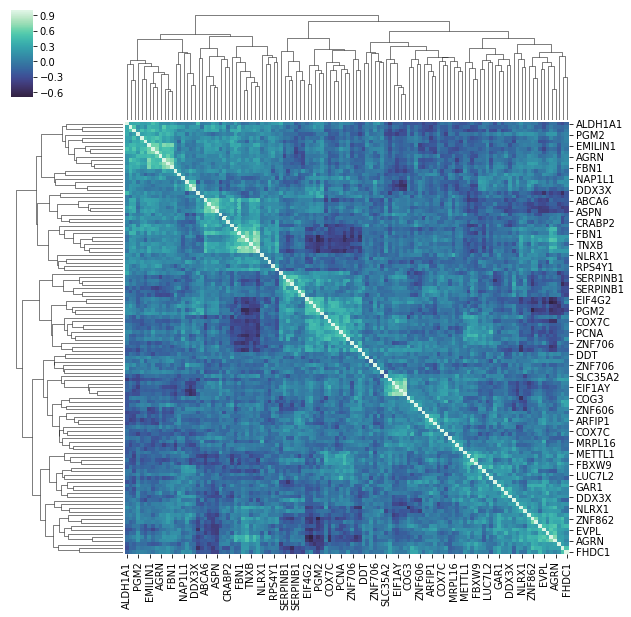

In [8]:
sns.clustermap(train_gender.corr(method='spearman'), 
               center=0, 
               cmap="mako")

In [14]:
train_gender_na = train_combined[[ # gender proteomics with 
                                    # more than 90% availability 
                                    'EMILIN1', 'EIF4G2', 'ARFIP1', 'GAR1',
                                    'TJP2', 'ALDH1A1', 'PGM2', 'LTBP1', 
                                    'NNMT', 'COX7C', 'FBN1',
                                    'SERPINB1', 'U2AF1L5', 'COG3','FBLN1',
                                    'FLNC', 'RCC2', 'COL4A2', 'S100A14', 
                                    'NAP1L1', 'AGRN',  
                                    
                                    # gender rna-seq with 
                                    # more than 90% availability 
                                    'ZFX', 'SRSF6', 'ZRSR2', 'RGS4', 
                                    'EVPL', 'LUC7L2', 'ZNF862', 'ODAM', 
                                    'FOXD2', 'PMS2P3', 'MND1', 'FAM3D', 
                                    'DDX3X', 'NINJ2', 'COCH', 'IRF5', 
                                    'FHDC1', 'ZNF606', 'DDB2', 
                                    'FBXW9', 'RPL21P28', 'TLX1', 'HEBP2', 
                                    'TRIM29', 'ZNF273', 'KCNJ2', 
                                    'CRABP2', 'ABCA6', 'MMP17', 'PCNA', 
                                    'S100A16', 'UBA6', 'EHBP1', 'THG1L',
                                ]]
columns = train_gender_na.columns

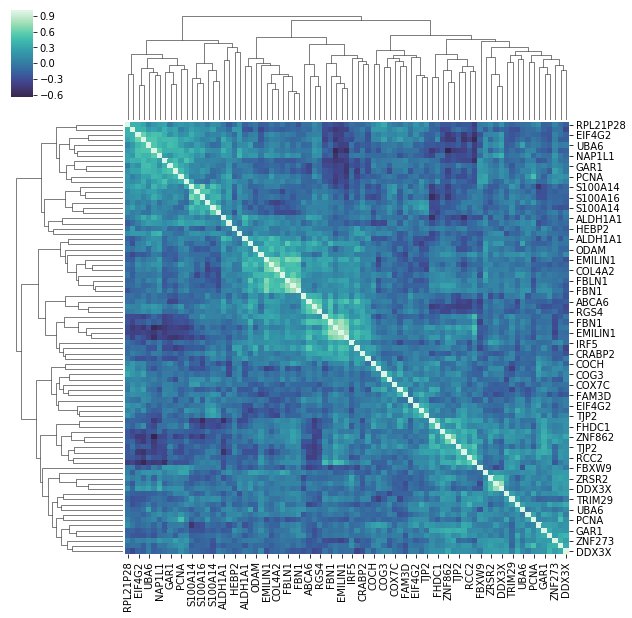

In [19]:
sns.clustermap(train_gender_na.corr(method='spearman'),
               center=0,
               cmap="mako")

#### It is shown in the end that combining data from proteomics and RNA-seq analyses imporves the predictive power of the classifer compared to those shown individually in each respective dataset. 

In [16]:
X_gender_train, X_gender_valid, y_gender_train, y_gender_valid =\
\
    train_test_split(train_gender_na.values.astype(int),
                     train_combined.gender.values, 
                     test_size=0.3)

 1) ZFX                            0.250878
 2) FLNC                           0.188181
 3) ZRSR2                          0.074359
 4) SERPINB1                       0.055229
 5) DDX3X                          0.026833
 6) TLX1                           0.024412
 7) COL4A2                         0.022354
 8) AGRN                           0.021954
 9) NINJ2                          0.021252
10) FBLN1                          0.016795
11) LUC7L2                         0.016512
12) LUC7L2                         0.014820
13) PGM2                           0.014819
14) TJP2                           0.014146
15) PCNA                           0.013130
16) SERPINB1                       0.012701
17) SRSF6                          0.009654
18) ALDH1A1                        0.009331
19) ABCA6                          0.008868
20) COL4A2                         0.007189
21) RPL21P28                       0.007135
22) ODAM                           0.006717
23) NNMT                        

<BarContainer object of 83 artists>

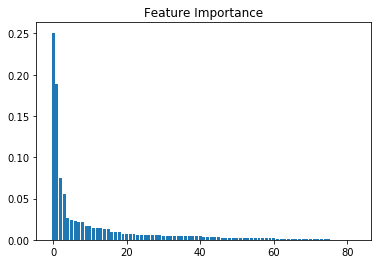

In [17]:
gender_forest = RandomForestClassifier(n_estimators=500, 
                                      min_samples_leaf=3,
                                      max_features=None,
                                      n_jobs=-1,
                                      oob_score=True)

gender_forest.fit(X_gender_train, y_gender_train)

gender_importances = gender_forest.feature_importances_
gender_indices = np.argsort(gender_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(len(columns)):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[gender_indices[f]], 
                            gender_importances[gender_indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_gender_train.shape[1]), 
        gender_importances[gender_indices], 
        align='center')

In [18]:
gender_select = SelectFromModel(gender_forest, threshold=0.00)

gender_select.fit(X_gender_train, y_gender_train)

X_gender_important_train = gender_select.transform(X_gender_train)
X_gender_important_train_df = pd.DataFrame(X_gender_important_train)
X_gender_important_valid = gender_select.transform(X_gender_valid)
gender_forest.fit(X_gender_important_train, y_gender_train)
y_gender_pred = gender_forest.predict(X_gender_important_valid)
print('Random Forest: \n', classification_report(y_true=y_gender_valid, 
                                                 y_pred=y_gender_pred))
print('OOB score: ', gender_forest.oob_score_)

Random Forest: 
              precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.95      0.95      0.95        19

avg / total       0.92      0.92      0.92        24

OOB score:  0.8035714285714286
